In [58]:
import numpy as np
import pandas as pd
import os
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from scipy.special import erfc
import scipy
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

from gen_simulation import create_picking

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [48]:
def get_scores(TN, FP, FN, TP):
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return TNR, FPR, FNR, TPR


def chauvenet(array):
    mean = array.mean()
    stdv = array.std()
    N = len(array)
    criterion = 1.0/(2*N)
    d = abs(array-mean)/stdv
    prob = erfc(d)
    return prob < criterion


def statistical_detection(weights, window_size=-1):

    weights = np.array(weights)
    preds = chauvenet(weights[0 if window_size == -1 else -window_size:])

    return preds[-1]


def test(weights, labels, window_size=-1, ret_cnt=False):
    accs = []
    tnrs, fprs, fnrs, tprs = [], [], [], []
    tns, fps, fns, tps = [], [], [], []

    preds, targets = [], []
    for t in range(len(weights)):
        pred = statistical_detection(weights[:t+1], window_size=window_size)
        preds.append(pred)
        targets.append(labels[t])
        tn, fp, fn, tp = confusion_matrix(
            targets, preds, labels=[0, 1]).ravel()
        tnr, fpr, fnr, tpr = get_scores(tn, fp, fn, tp)
        acc = np.sum(np.array(preds) == np.array(targets)) / (t + 1)

        accs.append(acc)
        tnrs.append(tnr)
        fprs.append(fpr)
        fnrs.append(fnr)
        tprs.append(tpr)

        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        tps.append(tp)

    if ret_cnt:
        return (accs, tnrs, fprs, fnrs, tprs), (tns, fps, fns, tps)
    return accs, tnrs, fprs, fnrs, tprs


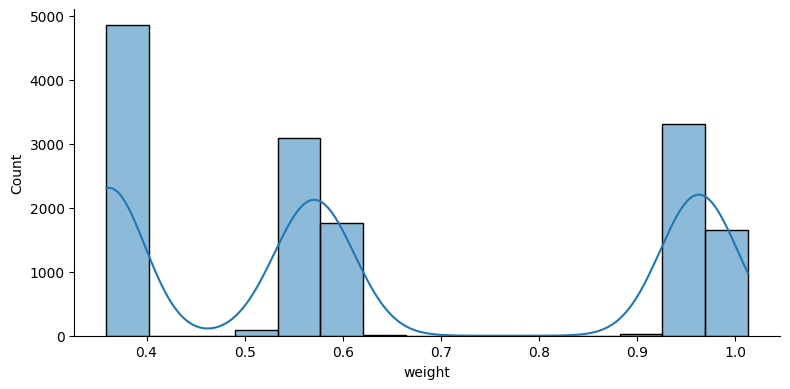

In [146]:
picking_df, product_df = create_picking(1000, 3, 2, 0.02)
picking_df = picking_df[picking_df['operation'] == 'PUT']
picking_df

sns.displot(picking_df, x="weight", kde=True, height=4, aspect=2)
plt.show()

In [112]:
picking_df, product_df = create_picking(1000, 10, 2, 0.02)
picking_df = picking_df[picking_df['operation'] == 'PUT']
picking_df

,worker_id,busket_id,product_id,weight,operation,label
0,0,573,9,0.825612,PUT,False
1,1,605,7,0.860311,PUT,False
2,1,865,3,0.837510,PUT,False
3,0,484,3,0.846702,PUT,False
4,0,71,8,0.422873,PUT,False
...,...,...,...,...,...,...
15903,0,584,3,0.829789,PUT,False
15905,0,625,1,0.068603,PUT,False
15907,1,312,2,0.017311,PUT,False
15909,0,168,1,0.067120,PUT,False


<Figure size 640x480 with 0 Axes>

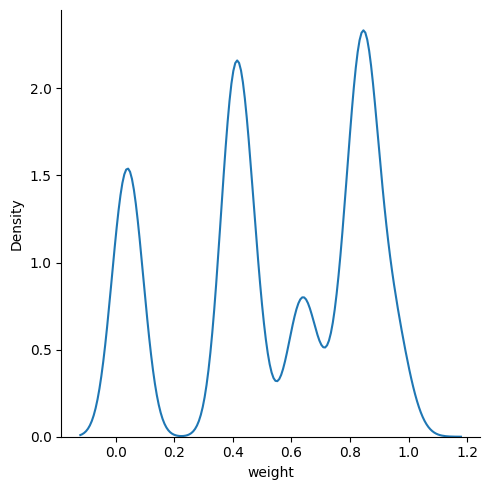

In [115]:
plt.figure(dpi=100)
sns.displot(picking_df, x="weight", kind="kde")
plt.show()

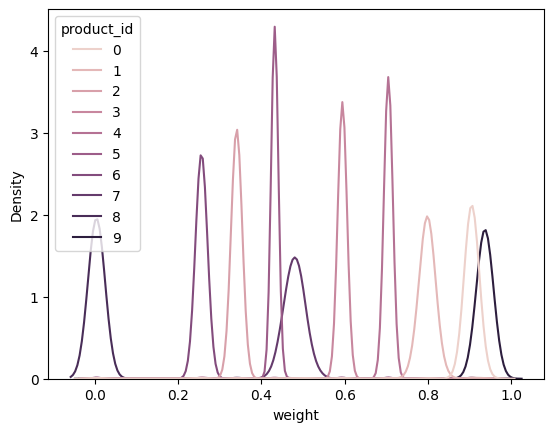

In [22]:
sns.kdeplot(data=picking_df, x="weight", hue="product_id")
plt.show()

In [23]:
product_id = 0

weights = picking_df[(picking_df['product_id'] == product_id) & (picking_df['operation'] == 'PUT')]['weight'].values
labels = picking_df[(picking_df['product_id'] == product_id) & (picking_df['operation'] == 'PUT')]['label'].values
weights, labels, np.sum(labels==True), weights.mean(), weights.std()

(array([0.90270336, 0.90350093, 0.89667675, ..., 0.90650104, 0.90641156,
        0.90730834]),
 array([False, False, False, ..., False, False, False]),
 31,
 0.8958467469018752,
 0.07493907373500962)

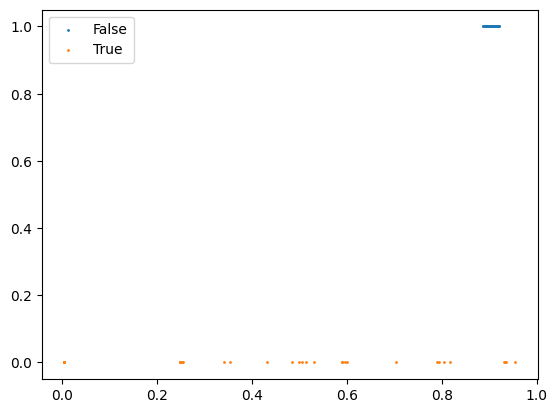

In [24]:
plt.scatter(weights[labels == False], np.ones_like(weights[labels == False]), s=1, label='False')
plt.scatter(weights[labels == True], np.zeros_like(weights[labels == True]), s=1, label='True')
#plt.xlim([0.11, 0.17])
plt.legend()
plt.show()

In [25]:
pred = chauvenet(weights)
tn, fp, fn, tp = confusion_matrix(labels, pred, labels=[0, 1]).ravel()
len(weights), np.sum(pred), np.sum(labels), np.sum(pred == labels) / len(weights), (tn, fp, fn, tp), get_scores(tn, fp, fn, tp)

(1465,
 23,
 31,
 0.9945392491467577,
 (1434, 0, 8, 23),
 (1.0, 0.0, 0.25806451612903225, 0.7419354838709677))

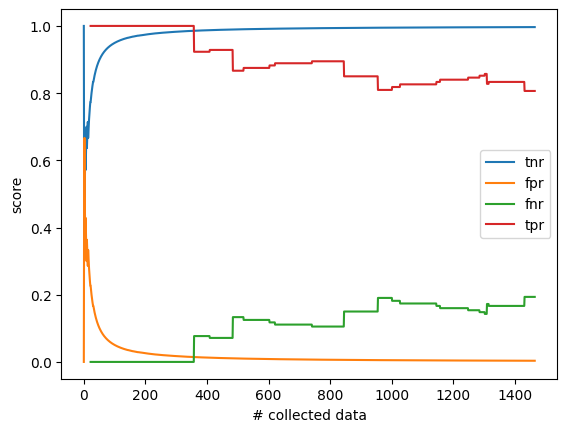

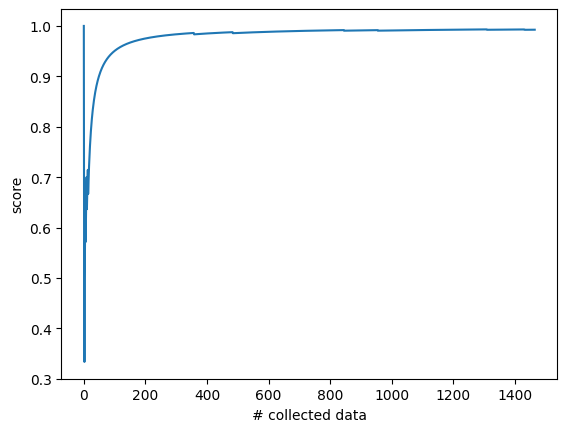

In [26]:
accs, tnrs, fprs, fnrs, tprs = test(weights, labels)

plt.plot(tnrs, label='tnr')
plt.plot(fprs, label='fpr')
plt.plot(fnrs, label='fnr')
plt.plot(tprs, label='tpr')
plt.xlabel('# collected data')
plt.ylabel('score')
plt.legend()
plt.show()

plt.plot(accs, label='accuracy')
plt.xlabel('# collected data')
plt.ylabel('score')
plt.show()

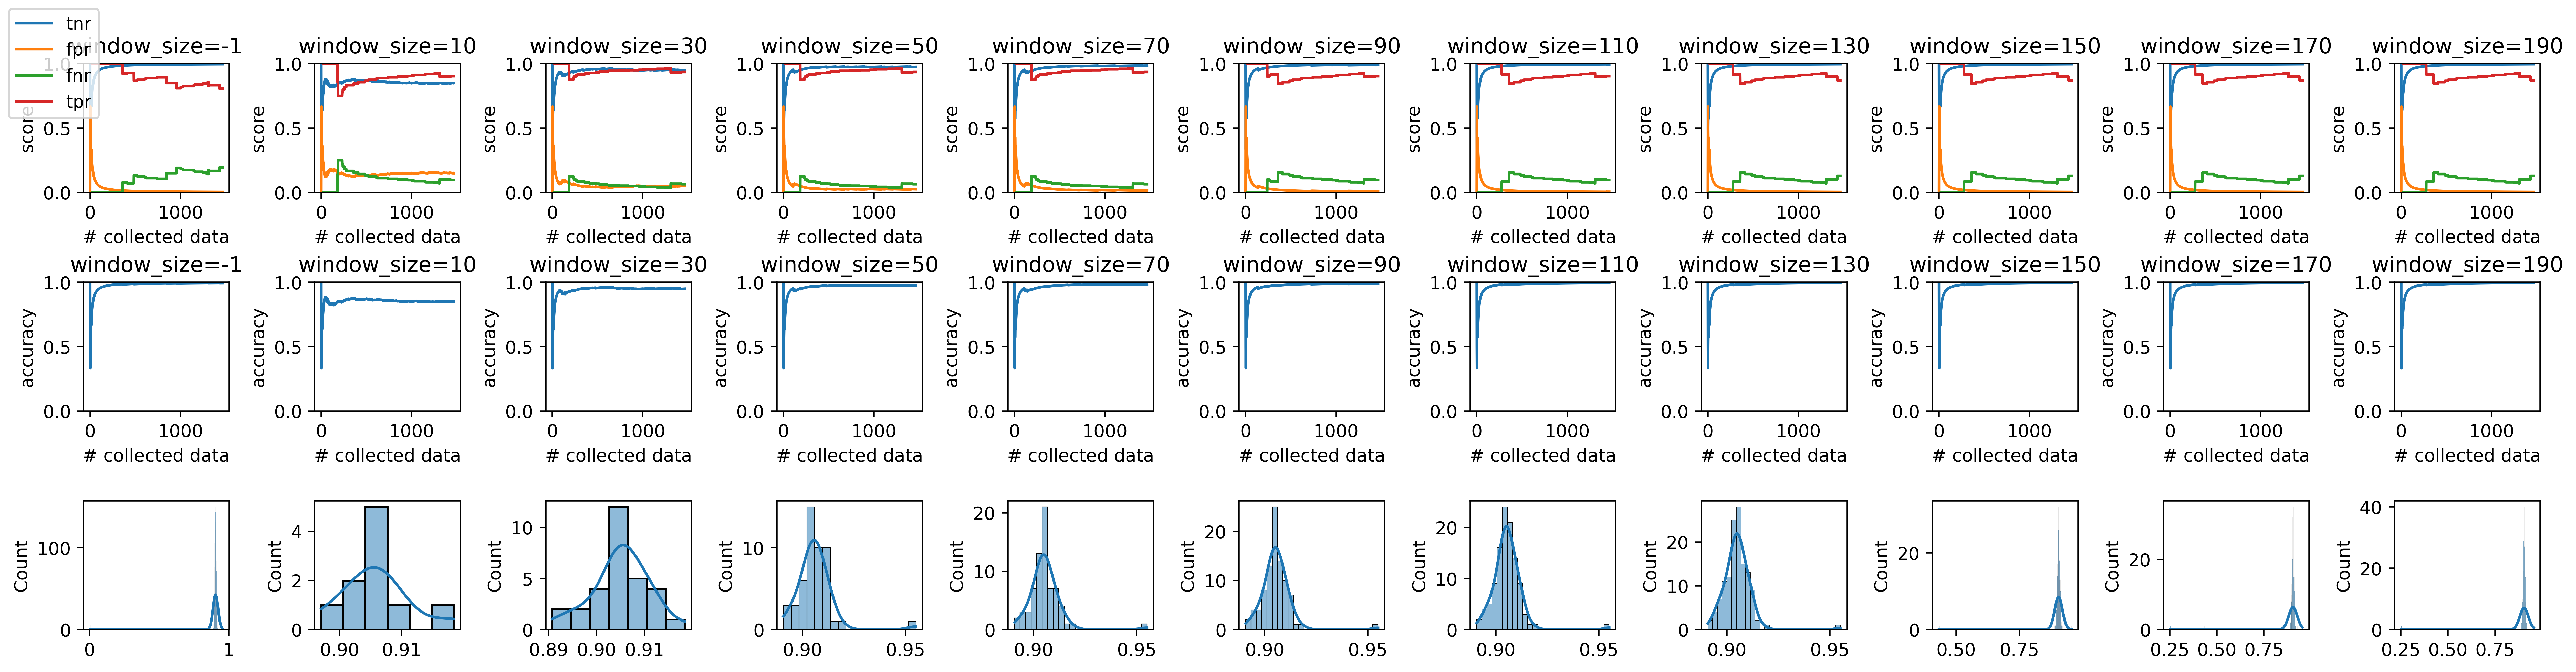

In [27]:
win_sizes = [-1] + list(range(10, 201, 20))

figure, axis = plt.subplots(3, len(win_sizes), dpi=500, figsize=(20,5))
figure.tight_layout(h_pad=3)
for idx, window_size in enumerate(win_sizes):

    accs, tnrs, fprs, fnrs, tprs = test(weights, labels, window_size=window_size)

    axis[0, idx].plot(tnrs, label='tnr')
    axis[0, idx].plot(fprs, label='fpr')
    axis[0, idx].plot(fnrs, label='fnr')
    axis[0, idx].plot(tprs, label='tpr')
    axis[0, idx].set_title(f'\nwindow_size={window_size}')
    axis[0, idx].set_xlabel('# collected data')
    axis[0, idx].set_ylabel('score')
    axis[0, idx].set_ylim([0, 1])

    axis[1, idx].plot(accs, label='accuracy')
    axis[1, idx].set_title(f'\nwindow_size={window_size}')
    axis[1, idx].set_xlabel('# collected data')
    axis[1, idx].set_ylabel('accuracy')
    axis[1, idx].set_ylim([0, 1])

    sns.histplot(weights[0 if window_size == -1 else -window_size:], kde=True, ax=axis[2, idx])

handles, plotlabels = axis[0, -1].get_legend_handles_labels()
figure.legend(handles, plotlabels, loc='upper left')
#plt.suptitle(f'product_id {product_id}')
plt.show()

778


  0%|          | 0/777 [00:00<?, ?it/s]

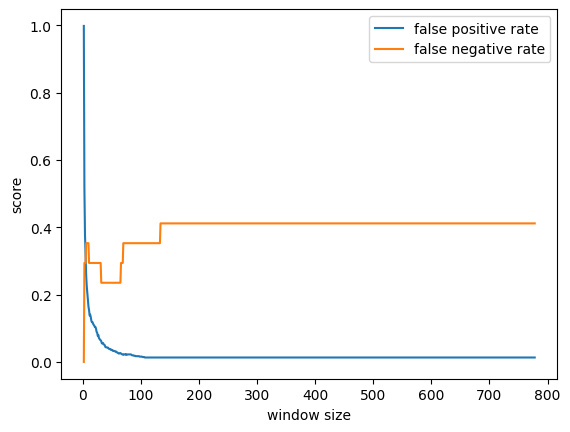

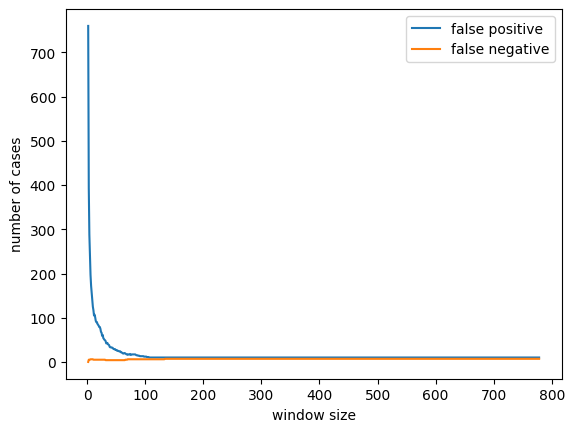

In [57]:
picking_df, product_df = create_picking(1000, 20, 2, 0.02)

weights = picking_df[(picking_df['product_id'] == 0) & (picking_df['operation'] == 'PUT')]['weight'].values
labels = picking_df[(picking_df['product_id'] == 0) & (picking_df['operation'] == 'PUT')]['label'].values

print(len(weights))

winsizes = list(range(2, len(weights) + 1, 1))
fprarr = []
fnrarr = []
tnarr = []
fparr = []
fnarr = []
tparr = []
for i, winsize in tqdm(enumerate(winsizes), total=len(winsizes)):
  (accs, tnrs, fprs, fnrs, tprs), (tns, fps, fns, tps) = test(weights, labels, window_size=winsize, ret_cnt=True)

  fprarr.append(fprs[-1])
  fnrarr.append(fnrs[-1])
  tnarr.append(tns[-1])
  fparr.append(fps[-1])
  fnarr.append(fns[-1])
  tparr.append(tps[-1])

plt.plot(winsizes, fprarr, label='false positive rate')
plt.plot(winsizes, fnrarr, label='false negative rate')
plt.xlabel('window size')
plt.ylabel('score')
plt.legend()
plt.show()

tnarr = np.array(tnarr)
fparr = np.array(fparr)
fnarr = np.array(fnarr)
tparr = np.array(tparr)
plt.plot(winsizes, fparr, label='false positive')
plt.plot(winsizes, fnarr, label='false negative')
plt.xlabel('window size')
plt.ylabel('number of cases')
plt.legend()
plt.show()

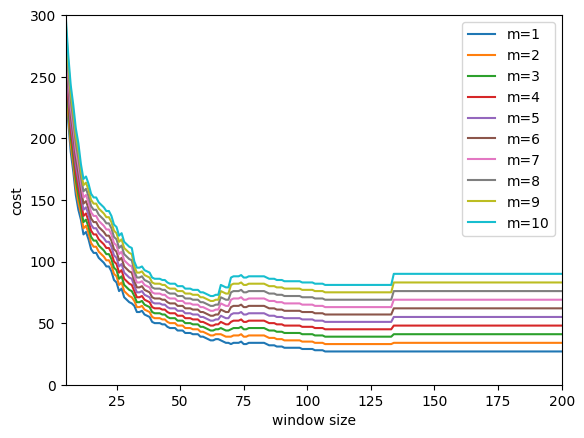

In [74]:
for m in range(1, 11, 1):
  plt.plot(winsizes, (fparr + tparr) + fnarr * m, label=f'm={m}')

plt.xlabel('window size')
plt.ylabel('cost')
plt.ylim([0, 300])
plt.xlim([5, 200])
plt.legend()
plt.show()

0.6296296296296297
1.0303030303030303
1.3076923076923077
1.511111111111111
1.6666666666666667
1.8214285714285714
1.9833333333333334
2.125
2.25
2.361111111111111


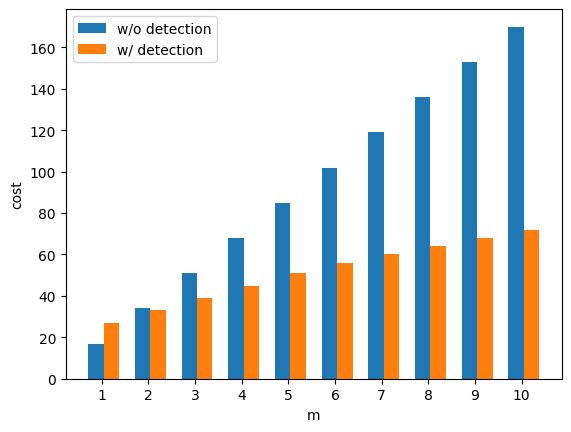

In [97]:
X = []
Y1, Y2 = [], []
for m in range(1, 11, 1):
  wo_detection = min((tparr + fnarr) * m)
  w_detection = min((fparr + tparr) + fnarr * m)
  X.append(m)
  Y1.append(wo_detection)
  Y2.append(w_detection)
  print(wo_detection / w_detection)
X = np.array(X)
Y1 = np.array(Y1)
Y2 = np.array(Y2)
plt.bar(X + 0.0 - 0.12, Y1, width=0.33, label='w/o detection')
plt.bar(X + 0.33 - 0.12, Y2, width=0.33, label='w/ detection')
plt.xlabel('m')
plt.ylabel('cost')
plt.xticks(X, X)
plt.legend()
plt.show()

In [109]:
num_products = list(range(0, 501, 15))[1:]
num_datas = list(range(0, 1501, 50))[1:]
trials = 10

heat_fp = np.zeros((len(num_datas), len(num_products)))
heat_fn = np.zeros((len(num_datas), len(num_products)))
heat_acc = np.zeros((len(num_datas), len(num_products)))

with tqdm(total=len(num_products)*len(num_datas)*trials) as pbar:
    for _ in range(trials):
        for i, num_product in enumerate(num_products):
            picking_df, product_df = create_picking(int(num_datas[-1] / 15 * num_product), num_product, 1, 0.02)

            weights = picking_df[(picking_df['product_id'] == 0) & (picking_df['operation'] == 'PUT')]['weight'].values
            labels = picking_df[(picking_df['product_id'] == 0) & (picking_df['operation'] == 'PUT')]['label'].values
            
            for j, num_data in enumerate(num_datas):
                accs, tnrs, fprs, fnrs, tprs = test(weights[:num_data], labels[:num_data], window_size=100)

                heat_fp[j, i] += fprs[-1]
                heat_fn[j, i] += fnrs[-1]
                heat_acc[j, i] += accs[-1]

                pbar.update(1)
heat_fp /= trials
heat_fn /= trials
heat_acc /= trials

  0%|          | 0/9900 [00:00<?, ?it/s]

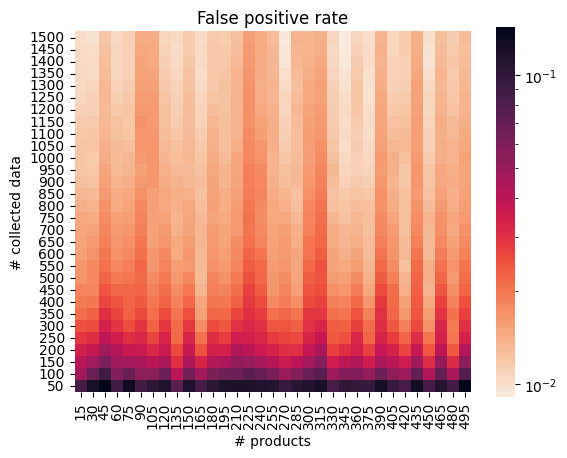

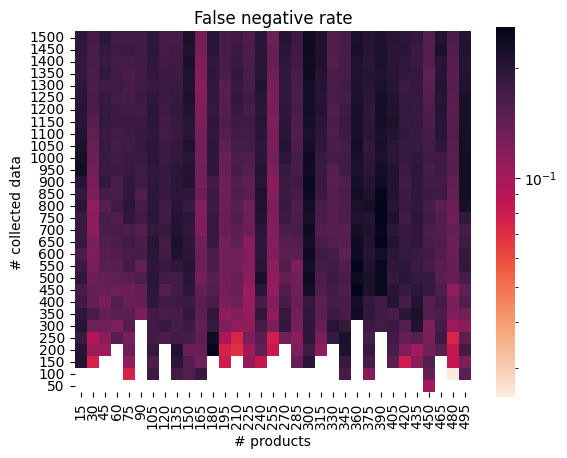

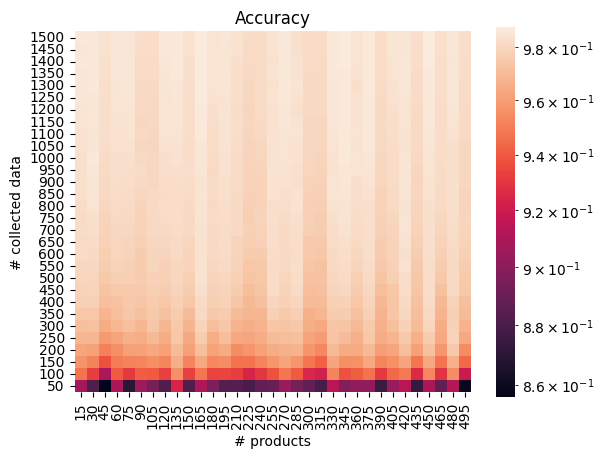

In [111]:
plt.figure(dpi=100)
ax = sns.heatmap(heat_fp[::-1,:], linewidth=0., cmap=sns.cm.rocket_r, square=True, norm=LogNorm()) # annot=True, fmt=".4f", 
plt.title('False positive rate')
plt.xlabel('# products')
plt.xticks([i + 0.5 for i in range(len(num_products))], num_products, rotation=90)
plt.ylabel('# collected data')
plt.yticks([i + 0.5 for i in range(len(num_datas))], num_datas[::-1], rotation=0)
plt.show()

plt.figure(dpi=100)
ax = sns.heatmap(heat_fn[::-1,:], linewidth=0., cmap=sns.cm.rocket_r, square=True, norm=LogNorm()) # annot=True, fmt=".4f", 
plt.title('False negative rate')
plt.xlabel('# products')
plt.xticks([i + 0.5 for i in range(len(num_products))], num_products, rotation=90)
plt.ylabel('# collected data')
plt.yticks([i + 0.5 for i in range(len(num_datas))], num_datas[::-1], rotation=0)
plt.show()

plt.figure(dpi=100)
ax = sns.heatmap(heat_acc[::-1,:], linewidth=0., square=True, norm=LogNorm()) # annot=True, fmt=".4f", 
plt.title('Accuracy')
plt.xlabel('# products')
plt.xticks([i + 0.5 for i in range(len(num_products))], num_products, rotation=90)
plt.ylabel('# collected data')
plt.yticks([i + 0.5 for i in range(len(num_datas))], num_datas[::-1], rotation=0)
plt.show()

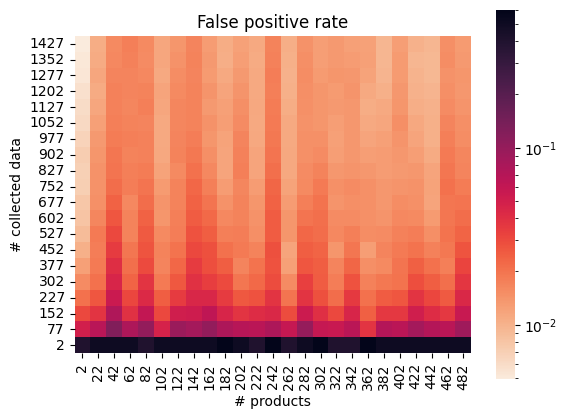

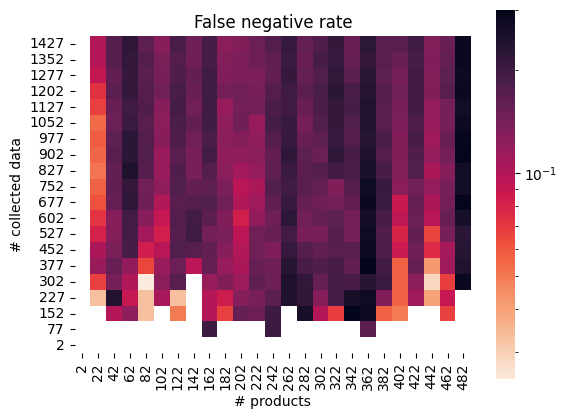

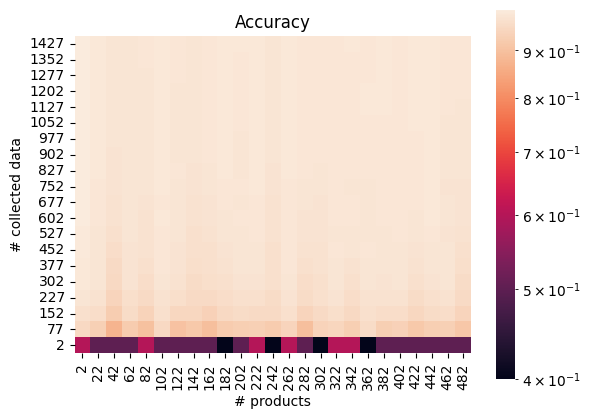

In [108]:
plt.figure(dpi=100)
ax = sns.heatmap(heat_fp[::-1,:], linewidth=0., cmap=sns.cm.rocket_r, square=True, norm=LogNorm()) # annot=True, fmt=".4f", 
plt.title('False positive rate')
plt.xlabel('# products')
plt.xticks([i + 0.5 for i in range(len(num_products))], num_products)
plt.ylabel('# collected data')
plt.yticks([i + 0.5 for i in range(len(num_datas))], num_datas[::-1], rotation=0)
plt.show()

plt.figure(dpi=100)
ax = sns.heatmap(heat_fn[::-1,:], linewidth=0., cmap=sns.cm.rocket_r, square=True, norm=LogNorm()) # annot=True, fmt=".4f", 
plt.title('False negative rate')
plt.xlabel('# products')
plt.xticks([i + 0.5 for i in range(len(num_products))], num_products)
plt.ylabel('# collected data')
plt.yticks([i + 0.5 for i in range(len(num_datas))], num_datas[::-1], rotation=0)
plt.show()

plt.figure(dpi=100)
ax = sns.heatmap(heat_acc[::-1,:], linewidth=0., square=True, norm=LogNorm()) # annot=True, fmt=".4f", 
plt.title('Accuracy')
plt.xlabel('# products')
plt.xticks([i + 0.5 for i in range(len(num_products))], num_products)
plt.ylabel('# collected data')
plt.yticks([i + 0.5 for i in range(len(num_datas))], num_datas[::-1], rotation=0)
plt.show()